In [1]:
#reload(mapmri)
from dipy.viz import fvtk
#from dipy.data import fetch_cenir_multib, read_cenir_multib, get_sphere
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from dipy.reconst import mapmri
from mapmri import mapmri

Populating the interactive namespace from numpy and matplotlib
(12, 12, 12, 6) (12, 12, 12, 6) [    5.  1000.  1995.  3005.   995.  2995.]


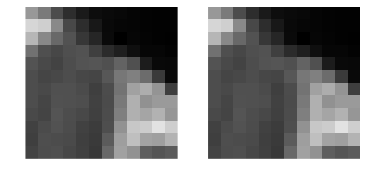

In [17]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import nibabel as nib


def load_subject(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        gtab = gradient_table(bvals=bvals[bvalpos], bvecs=bvecs[:,bvalpos])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        gtab = gradient_table(bvals=bvals, bvecs=bvecs)
    return img, gtab

subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
bvals5pos = [0,16,32,48,64,80,95,112,128,144,160,176,191,208,224,240,256,272]
# Esto es para quedame con la gtab que es igua a todos
img, gtab = load_subject(0 , subjects)

img_s0, gtab_s0 = load_subject(0, subjects, bval=5, bvalpos=bvals5pos[0:6])

i_hr=img.get_data()
S0 = img_s0.get_data()

gtab = gradient_table(bvals=gtab.bvals[0:6], bvecs=gtab.bvecs[0:6])

#print('data.shape (%d, %d, %d, %d)' % data.shape)
img_utils._isc(S0, i_hr, y=0, vmin=S0.min(),  vmax=S0.max())
print S0.shape, i_hr.shape, gtab.bvals

In [18]:
radial_order = 4
reload(mapmri)
map_model = mapmri.MapmriModel(gtab,
                            radial_order=radial_order,
                            anisotropic_scaling=False)#,
                            #dti_scale_estimation=False)

# en la version de dipy no mete el mu en self.mu por eso no es robable
# ademas dti_scale desaparece
"""
mu = map_model.mu
print mu.shape
tau = 1 / (4 * np.pi ** 2) # hasta encontrar el big y small delta en HCP
qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
q = gtab.bvecs * qvals[:, None]
M = mapmri.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
print M.shape, mu.shape
"""

'\nmu = map_model.mu\nprint mu.shape\ntau = 1 / (4 * np.pi ** 2) # hasta encontrar el big y small delta en HCP\nqvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)\nq = gtab.bvecs * qvals[:, None]\nM = mapmri.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)\nprint M.shape, mu.shape\n'

In [5]:
map_model_fit = map_model.fit(i_hr)

NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro deonde queria
NO entro de

In [6]:
map_model_fit.qiv()

array([[[  2.20550821e-11,   1.87791343e-10,   3.04913231e-10, ...,
           3.46279430e-10,   2.20550821e-11,   2.46543919e-10],
        [  2.20550821e-11,   2.20550821e-11,   2.20550821e-11, ...,
           2.93914405e-10,   3.07654914e-10,   1.15049281e-10],
        [  2.20550821e-11,   2.20550821e-11,   3.45505735e-11, ...,
           3.38046114e-10,   2.62452048e-10,   2.20550821e-11],
        ..., 
        [  2.20550821e-11,   2.20550821e-11,   2.20550821e-11, ...,
           3.89208952e-10,   3.03479080e-10,   3.68174457e-10],
        [  2.20550821e-11,   2.76273170e-10,   3.53674578e-10, ...,
           3.82927277e-10,   2.20550821e-11,   1.14858019e-10],
        [  2.20550821e-11,   2.20550821e-11,   3.35678371e-10, ...,
           2.77506971e-10,   3.77910821e-10,   2.91993676e-10]],

       [[  3.54905159e-10,   3.56914528e-10,   2.20550821e-11, ...,
           3.22802832e-10,   2.20550821e-11,   2.51245812e-10],
        [  2.20550821e-11,   2.95412800e-10,   2.10493962e-1

In [15]:
#print type(map_model_fit), type(map_model)
relative_err = (map_model_fit[0,0,0].predict(gtab, S0[0,0,0,:])-i_hr[0,0,0, :])/i_hr[0,0,0, :]
print 'predict(q)', map_model_fit[0,0,0].fitted_signal(gtab)*S0[0,0,0,0]
print 'Eq', i_hr[0,0,0, :]
mpl = map_model_fit[0,0,0].fitted_signal(gtab)*S0[0,0,0,0]

(mpl-i_hr[0,0,0, :])/i_hr[0,0,0, :]

por calcular M
predict(q) por calcular M
[ 4297.4765886   2978.38142099  3713.90004004  4352.4208532   3710.11883191
  3834.74377905]
Eq [ 1486.32556152   731.22900391  1113.76867676  1505.38269043  1305.67541504
  1177.0637207 ]
por calcular M


array([ 1.89134272,  3.07311718,  2.33453447,  1.89123881,  1.84153227,
        2.25788971])

In [44]:
import cvxpy as cvx



C = cvx.Variable()